In [1]:
!pip install qutip --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 42.2 MB/s eta 0:00:00


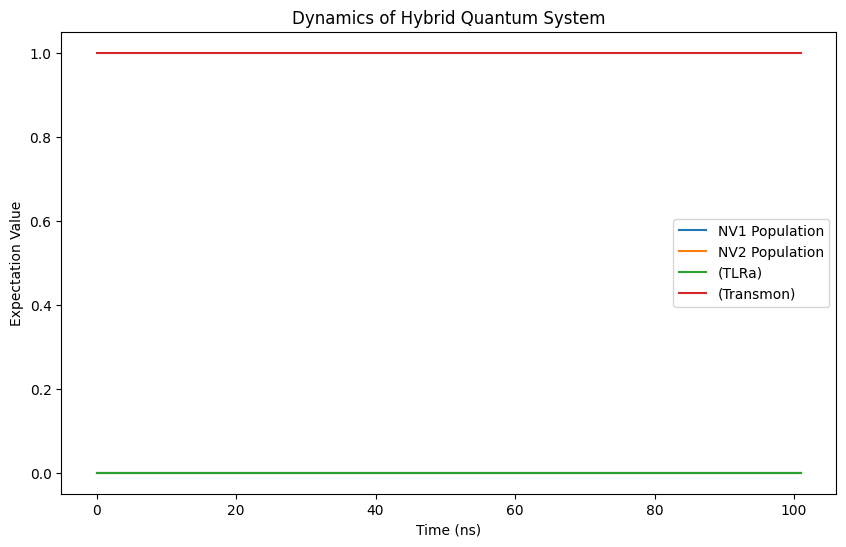

In [2]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt


g_a, g_b = [26 * 2 * np.pi] * 2
g1, g2 = [7 * 2 * np.pi] * 2
omega_a, omega_b = [2.8 * 10 * np.pi] * 2
omega_eg = omega_ge1 = omega_gu1 = omega_ge2 = omega_gu2 = 2.0 * 2 * np.pi

delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg
delta1_ge = omega_a - omega_ge1
delta1_gu = omega_a - omega_gu1
delta2_ge = omega_b - omega_ge2
delta2_gu = omega_b - omega_gu2

times = np.linspace(0, 101e-9, 1000)
resonator_levels, qubit_levels, NVE1_levels, NVE2_levels = 2, 2, 3, 3

def tensor_op(*ops): return qt.tensor(*ops)

a = tensor_op(qt.destroy(2), qt.qeye(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
b = tensor_op(qt.qeye(2), qt.destroy(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
sigma_plus = tensor_op(qt.qeye(2), qt.qeye(2), qt.create(2), qt.qeye(3), qt.qeye(3))
sigma_minus = tensor_op(qt.qeye(2), qt.qeye(2), qt.destroy(2), qt.qeye(3), qt.qeye(3))

def S_op(NVE_level, idx1, idx2, NVE_idx):
    ops = [qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(3), qt.qeye(3)]
    ops[NVE_idx] = qt.basis(NVE_level, idx1) * qt.basis(NVE_level, idx2).dag()
    return tensor_op(*ops)

S1_ge_plus, S1_ge_minus = S_op(3, 1, 0, 3), S_op(3, 0, 1, 3)
S1_gu_plus, S1_gu_minus = S_op(3, 2, 0, 3), S_op(3, 0, 2, 3)
S2_ge_plus, S2_ge_minus = S_op(3, 1, 0, 4), S_op(3, 0, 1, 4)
S2_gu_plus, S2_gu_minus = S_op(3, 2, 0, 4), S_op(3, 0, 2, 4)

t0, sigma = 50e-9, 10e-9

H_t = [
    [a * sigma_plus, lambda t, args: np.exp(1j * delta_a * t)],
    [a.dag() * sigma_minus, lambda t, args: np.exp(-1j * delta_a * t)],
    [b * sigma_plus, lambda t, args: np.exp(1j * delta_b * t)],
    [b.dag() * sigma_minus, lambda t, args: np.exp(-1j * delta_b * t)],

    [a * S1_ge_plus, lambda t, args: np.exp(1j * delta1_ge * t)],
    [a.dag() * S1_ge_minus, lambda t, args: np.exp(-1j * delta1_ge * t)],
    [a * S1_gu_plus, lambda t, args: np.exp(1j * delta1_gu * t)],
    [a.dag() * S1_gu_minus, lambda t, args: np.exp(-1j * delta1_gu * t)],
    [b * S2_ge_plus, lambda t, args: np.exp(1j * delta2_ge * t)],
    [b.dag() * S2_ge_minus, lambda t, args: np.exp(-1j * delta2_ge * t)],
    [b * S2_gu_plus, lambda t, args: np.exp(1j * delta2_gu * t)],
    [b.dag() * S2_gu_minus, lambda t, args: np.exp(-1j * delta2_gu * t)],

    [a, lambda t, args: np.exp(-((t - t0) ** 2) / (2 * sigma ** 2)) * np.exp(1j * delta_a * t)],
    [a.dag(), lambda t, args: np.conj(np.exp(-((t - t0) ** 2) / (2 * sigma ** 2)) * np.exp(1j * delta_a * t))],
    [b, lambda t, args: np.exp(-((t - t0) ** 2) / (2 * sigma ** 2)) * np.exp(1j * delta_b * t)],
    [b.dag(), lambda t, args: np.exp(-((t - t0) ** 2) / (2 * sigma ** 2)) * np.exp(-1j * delta_b * t)],
]

kappa = gamma_q = gamma_phi_q = 1 / 20e-6
c_ops = [np.sqrt(kappa) * a, np.sqrt(kappa) * b, np.sqrt(gamma_q) * sigma_minus, np.sqrt(gamma_phi_q) * sigma_plus * sigma_minus]

psi0 = tensor_op(qt.basis(2, 0), qt.basis(2, 0), qt.basis(2, 0), qt.basis(3, 0), qt.basis(3, 0))

pop_NVE1_e = S1_ge_plus * S1_ge_minus
pop_NVE2_e = S2_ge_plus * S2_ge_minus
photon_number_a = a.dag() * a
qubit_pop = sigma_plus.dag() * sigma_plus
result = qt.mesolve(H_t, psi0, times, c_ops, e_ops=[pop_NVE1_e, pop_NVE2_e, photon_number_a, qubit_pop])


plt.figure(figsize=(10, 6))
plt.plot(times * 1e9, result.expect[0], label="NV1 Population")
plt.plot(times * 1e9, result.expect[1], label="NV2 Population")
plt.plot(times * 1e9, result.expect[2], label=r"(TLRa)")
plt.plot(times * 1e9, result.expect[3], label=r"(Transmon)")
plt.xlabel("Time (ns)")
plt.ylabel("Expectation Value")
plt.legend()
plt.title("Dynamics of Hybrid Quantum System")
plt.show()